DL - https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [2]:
import os
import pandas as pd 
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize as tokenize
from nltk.corpus import stopwords as stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch import nn
from tqdm import tqdm
import uuid
import re
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /Users/rfd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rfd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rfd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)


parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')


IN COLAB:  False


In [30]:
def transform_binaryify(row):
    new_value = 0 if row['label'] == 'not_propaganda' else 1
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


train_df['propaganda'] = train_df.apply(transform_binaryify, axis=1)
train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)


val_df['propaganda'] = val_df.apply(transform_binaryify, axis=1)
val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)

train_df
val_df

,label,tagged_in_context,propaganda,original_without_snip_tags
0,not_propaganda,"On average, between 300 and 600 infections are...",0,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1,Mostly because the country would not last lon...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1,Lyndon Johnson gets Earl Warren and Sen. Rich...
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0,You may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...,1,It must be exacted from him directly in order ...
...,...,...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...",0,"NewsCatholic Church, Family, Marriage"
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",0,"Remember our saying, modern day fairy tales s..."
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,0,Why not open up to Iran with massive amounts...
638,flag_waving,<BOS> He also sang an Islamic State fight song...,1,He also sang an Islamic State fight song and ...


In [31]:

#replace with the path where you have downloaded your model.
pretrained_model_path = './GoogleNews-vectors-negative300.bin.gz' 
#initialise the pre trained model using load_word2vec_format from gensim module.
my_model = KeyedVectors.load_word2vec_format(pretrained_model_path, binary=True, limit=999999)
 

In [52]:
def transform_tokens_to_w2v_with_stems(string, model, pool_type='mean', normalise = False):
    stops = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()
    snowball_stemmer = SnowballStemmer('english')
    vectors = []
    original_tokens = tokenize(string)
    cleaned_tokens = [w for w in original_tokens if len(w) > 1 and w.isalpha() and w not in stops]
    
    for token in cleaned_tokens:
        if token in model.key_to_index:
            vectors.append(model.get_vector(token, norm=normalise))
        else:
            porter_stem = porter_stemmer.stem(token)
            snowball_stem = snowball_stemmer.stem(token)
            if porter_stem in model.key_to_index:
                vectors.append(model.get_vector(porter_stem, norm=normalise))
            elif snowball_stem in model.key_to_index:
                vectors.append(model.get_vector(snowball_stem, norm=normalise))
    
    if not vectors:
        return np.zeros(300)
    
    if pool_type == 'mean':
        return np.mean(vectors, axis=0)
    elif pool_type == 'max':
        return np.max(vectors, axis=0)
    elif pool_type == 'mult':
        result = np.ones(300)
        for vector in vectors:
            result *= vector
        return result
    else:
        raise ValueError("Invalid pool_type. Choose either 'mean' or 'max' or 'mult'.")

def precompute_sif_weights(model, a=1e-3):
    corpus_total_words = sum(model.get_vecattr(word, 'count') for word in model.key_to_index)
    word_weights = {word: a / (a + model.get_vecattr(word, 'count') / corpus_total_words) for word in model.key_to_index}
    return word_weights, corpus_total_words

def transform_tokens_to_w2v_no_stems(string, model, pool_type='mean', normalise=False, word_weights=None, corpus_total_words=None):
    vectors = []
    legit_tokens = []
    stops = set(stopwords.words('english'))
    original_tokens = tokenize(string)
    cleaned_tokens = [w for w in original_tokens if len(w) > 1 and w.isalpha() and w not in stops]

    for token in cleaned_tokens:
        if token in model.key_to_index:
            legit_tokens.append(token)
            vectors.append(model.get_vector(token, norm=normalise))

    if not vectors:
        return np.zeros(300)

    if pool_type == 'mean':
        return np.mean(vectors, axis=0)
    elif pool_type == 'max':
        return np.max(vectors, axis=0)
    elif pool_type == 'mult':
        result = np.ones(300)
        for vector in vectors:
            result *= vector
        return result
    elif pool_type == 'sif':
        if word_weights is None or corpus_total_words is None:
            raise ValueError("Word weights and corpus total words must be provided for SIF pooling.")

        # Compute the weighted average of word vectors
        weighted_average = np.zeros(300)
        word_weights_sum = sum(word_weights[token] for token in legit_tokens)
        for token, vector in zip(legit_tokens, vectors):
            weighted_average += word_weights[token] * vector
        weighted_average /= word_weights_sum

        # Perform common component removal
        pc = np.mean(vectors, axis=0)
        weighted_average -= np.dot(weighted_average, pc) * pc

        return weighted_average
    else:
        raise ValueError("Invalid pool_type. Choose either 'mean', 'max', 'mult', or 'sif'.")

In [53]:
class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, model, stems=False, norm = False, pool = 'mean'):
        self.word_weights, self.corpus_total_words = precompute_sif_weights(model)

        self.stems = stems
        self.labels=torch.tensor([label for label in df['propaganda']])
        
        if self.stems==True:
            self.texts=torch.tensor([transform_tokens_to_w2v_with_stems(string, model, normalise = norm, pool_type=pool) for string in df['original_without_snip_tags']])
        else:
            self.texts=torch.tensor([transform_tokens_to_w2v_no_stems(string, model, normalise = norm, pool_type=pool, word_weights=self.word_weights, corpus_total_words=self.corpus_total_words) for string in df['original_without_snip_tags']])
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        texts=self.texts[idx]
        y=self.labels[idx]
        return texts,y



In [5]:
from torchsummary import summary

class Custom_MLP_W2V(nn.Module):
    def __init__(self, dropout=0.5, num_classes=2): # num_classes = 8 for multiclass
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(300, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.linear_2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)  
        self.linear_3 = nn.Linear(128, num_classes)

    def forward(self, inputs):
        x = self.linear_1(inputs)
        x = self.bn1(x)  
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.bn2(x)  
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_3(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          38,528
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 2]             258
Total params: 55,810
Trainable params: 55,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.21
Estimated Total Size (MB): 0.22
-----------------------------------------

In [55]:
epochs =100
lr = 5e-5
n_classes = 2

Epochs: 1 | Train Loss: 0.007 | Train Accuracy: 0.567
Val loss: 0.008 | Val Accuracy: 0.483
Epochs: 2 | Train Loss: 0.006 | Train Accuracy: 0.676
Val loss: 0.008 | Val Accuracy: 0.483
Epochs: 3 | Train Loss: 0.006 | Train Accuracy: 0.706
Val loss: 0.007 | Val Accuracy: 0.625
Epochs: 4 | Train Loss: 0.006 | Train Accuracy: 0.725
Val loss: 0.006 | Val Accuracy: 0.728
Epochs: 5 | Train Loss: 0.005 | Train Accuracy: 0.748
Val loss: 0.006 | Val Accuracy: 0.730
Epochs: 6 | Train Loss: 0.005 | Train Accuracy: 0.766
Val loss: 0.006 | Val Accuracy: 0.725
Epochs: 7 | Train Loss: 0.005 | Train Accuracy: 0.769
Val loss: 0.006 | Val Accuracy: 0.731
Epochs: 8 | Train Loss: 0.005 | Train Accuracy: 0.781
Val loss: 0.006 | Val Accuracy: 0.734
Epochs: 9 | Train Loss: 0.004 | Train Accuracy: 0.787
Val loss: 0.006 | Val Accuracy: 0.741
Epochs: 10 | Train Loss: 0.004 | Train Accuracy: 0.812
Val loss: 0.006 | Val Accuracy: 0.741
Epochs: 11 | Train Loss: 0.004 | Train Accuracy: 0.813
Val loss: 0.006 | Val Ac

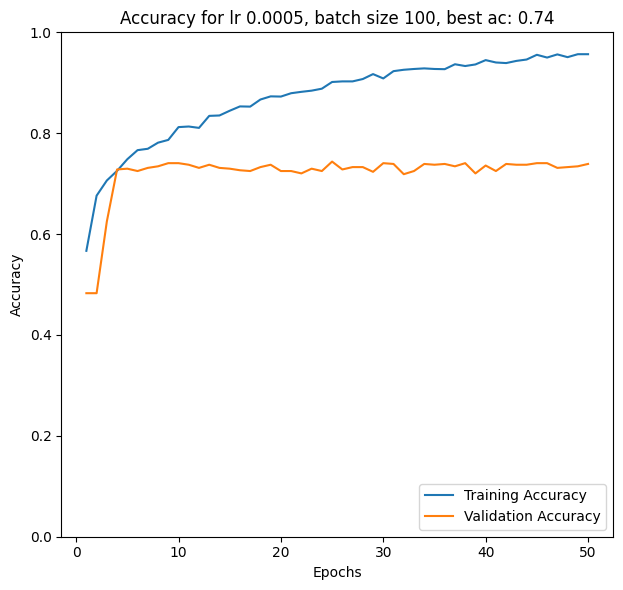

Classification Report:
              precision    recall  f1-score   support

     class 0       0.74      0.77      0.76       331
     class 1       0.74      0.72      0.73       309

    accuracy                           0.74       640
   macro avg       0.74      0.74      0.74       640
weighted avg       0.74      0.74      0.74       640

Epochs: 1 | Train Loss: 0.007 | Train Accuracy: 0.585
Val loss: 0.008 | Val Accuracy: 0.483
Epochs: 2 | Train Loss: 0.006 | Train Accuracy: 0.673
Val loss: 0.009 | Val Accuracy: 0.484
Epochs: 3 | Train Loss: 0.006 | Train Accuracy: 0.714
Val loss: 0.007 | Val Accuracy: 0.656
Epochs: 4 | Train Loss: 0.005 | Train Accuracy: 0.737
Val loss: 0.006 | Val Accuracy: 0.723
Epochs: 5 | Train Loss: 0.005 | Train Accuracy: 0.747
Val loss: 0.006 | Val Accuracy: 0.719
Epochs: 6 | Train Loss: 0.005 | Train Accuracy: 0.761
Val loss: 0.006 | Val Accuracy: 0.720
Epochs: 7 | Train Loss: 0.005 | Train Accuracy: 0.775
Val loss: 0.006 | Val Accuracy: 0.723
Epochs

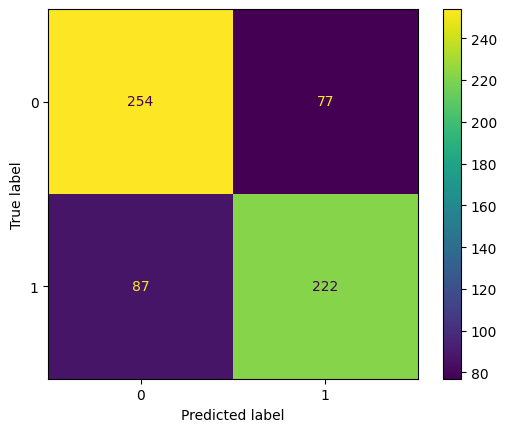

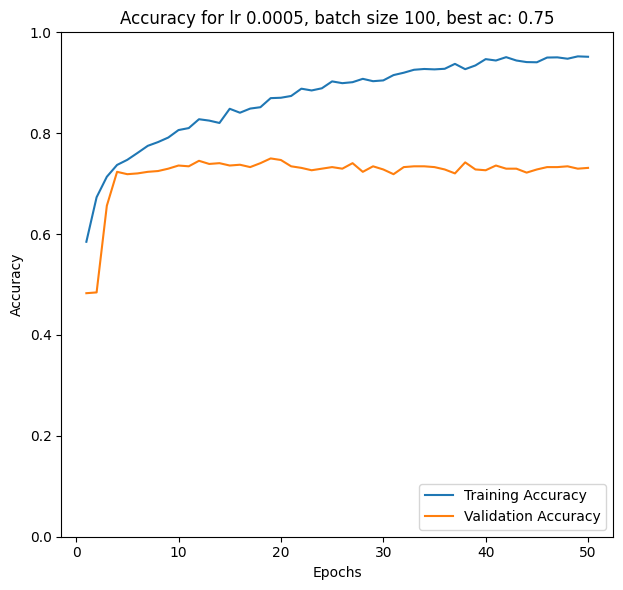

Classification Report:
              precision    recall  f1-score   support

     class 0       0.78      0.71      0.75       331
     class 1       0.72      0.79      0.75       309

    accuracy                           0.75       640
   macro avg       0.75      0.75      0.75       640
weighted avg       0.75      0.75      0.75       640



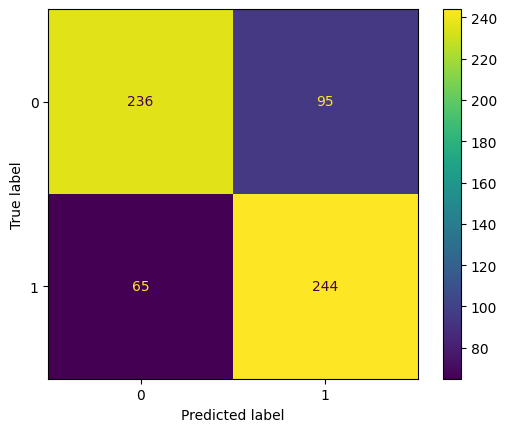

In [58]:
epochs =50
n_classes = 2
bn = 100
lr = 5e-4
stem_v = False
pool_v = 'mean'
norm_v = True
dr = 0.5



for pool_v in ['sif', 'mean']:

    train_data = CustomPropagandaDataset_vanilla(train_df, my_model, stems=stem_v, norm = norm_v, pool=pool_v)
    val_data = CustomPropagandaDataset_vanilla(val_df, my_model, stems=stem_v, norm = norm_v, pool=pool_v)
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=bn,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=bn)

    model=Custom_MLP(num_classes=n_classes, dropout=dr).to(device)
    criterion=nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    best_val_acc = 0
    best_epoch = 0
    best_model_state = None

    model_id = str(uuid.uuid4())


    for epoch_num in range(epochs):

        total_acc_train=0
        total_loss_train=0
        model.train()

        for train_input,train_label in train_dataloader:

            train_input = train_input.to(device).float()
            train_label = train_label.to(device)
            output_1=model(train_input)

            batch_loss_1=criterion(output_1,train_label)

            total_loss_train += batch_loss_1.item()

            acc=(output_1.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss_1.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0

        y_true = []
        y_pred = []
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                val_input = val_input.to(device).float()
                val_label = val_label.to(device)

                output_2=model(val_input)

                batch_loss_2=criterion(output_2,val_label)

                total_loss_val+=batch_loss_2.item()

                acc=(output_2.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc

                # for scoring
                predicted = output_2.argmax(dim=1)
                y_true.extend(val_label.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        
        train_acc = total_acc_train / len(train_data)
        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        if val_acc > best_val_acc:
            best_epoch = epoch_num
            y_true_best = y_true.copy()
            y_pred_best = y_pred.copy()
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        if epoch_num == epochs-1:
            print(f'______{model_id}______')
            print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
            print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
            print('____________')
            
    # Plot the accuracy and loss curves over epochs
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
    plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
    plt.title(f'Accuracy for lr {lr}, batch size {bn}, best ac: {best_val_acc:.2f}')

    # plt.subplot(1, 2, 2)
    # plt.plot(epochs_range, train_loss_list, label='Training Loss')
    # plt.plot(epochs_range, val_loss_list, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend(loc='upper right')
    # plt.title('Loss Curves')

    plt.tight_layout()
    plt.show()
    # analysis of best performing model
    
    # analysis of best performing model
    cm = confusion_matrix(y_true_best, y_pred_best)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    # Compute precision, recall, F1-score, and other metrics for the best model
    report = classification_report(y_true_best, y_pred_best, target_names=['class 0', 'class 1'])
    print('Classification Report:')
    print(report)

    results_dict = {
        'model_id': model_id,
        'train_accuracy': train_acc_list,
        'train_loss': train_loss_list,
        'val_accuracy': val_acc_list,
        'val_loss': val_loss_list,
        'hyperparameters': {
            'learning_rate': lr,
            'num_epochs': epochs,
            'batch_size': bn,
            'stem_v':stem_v,
            'pool_v':pool_v,
            'norm_v':norm_v,
            'dropout_rate': dr,
        },
        'results': {
            "classes": n_classes,
            "last_acc": val_acc_list[-1],
            'best_acc': best_val_acc,
            'best_acc_epoch': best_epoch,
            'confusion_matrix': cm.tolist(),
            'classification_report': report
        }
    }


    # Save the results dictionary as a JSON file with the model ID
    results_filename = f'./results/w2v_binary/w2v_binary_results_{model_id}.json'
    with open(results_filename, 'w') as f:
        json.dump(results_dict, f, indent=4)